# News ETA: Statistical and Visual Exploration
Becky Desrosiers | rn7ena@virginia.edu | DS5001 F24 | 13 December, 2024

## Previously: Text preparation into forms F2-F5 were addressed in [rn7ena_news_processing.ipynb](rn7ena_news_processing.ipynb)

## Imports and data

In [25]:
import pandas as pd
from helper import MyDB
from numpy import datetime64
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.manifold import TSNE
import plotly.express as px
from IPython.display import display_html
from gensim.models.word2vec import Word2Vec
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

f5 = MyDB('tables/F5')
LIBRARY = f5.get_table('Library').set_index('doc_id')
LIBRARY.doc_date = pd.to_datetime(LIBRARY.doc_date)
LIBRARY['doc_month'] = LIBRARY.doc_date.dt.strftime('%Y-%m')
DOC = f5.get_table('Document').set_index('doc_id')
TOKEN = f5.get_table('Token')
VOCAB = f5.get_table('Vocabulary').set_index('term_id')
PCS = f5.get_table('Principal_Components').set_index('principal_component')
LOADINGS = f5.get_table('Loadings').set_index('term_id')
THETA = f5.get_table('Theta').set_index('doc_id')
PHI = f5.get_table('Phi')
TOPICS = f5.get_table('Topics').set_index('topic_id')
VECTORS = f5.get_table('Vectors').set_index('term_id')
SENTIMENTS = f5.get_table('Sentiments').set_index('term_id')
TFIDF = pd.read_csv('tables/TFIDF.csv', index_col = 'term_id')
vector_model = Word2Vec.load('word2vec.model')

## Summarizing the dataset

To categorize by political leanings, I used www.allsides.com and www.mediabiasfactcheck.com.

#### Code

In [26]:
less_common_sources = LIBRARY.doc_source.value_counts().loc[LIBRARY.doc_source.value_counts() < 200].index
liberal_sources = ['US News', 'CNN', 'NPR', 'New York Times', 'Politico Magazine',
                   'Google News', 'Daily Kos', 'Guardian']
conservative_sources = ['Fox', 'Breitbart', 'PowerLine']
center_sources = ['UPI Latest', 'Real Clear Politics', 'Drudge Report', 'Reuters']
LIBRARY['collapsed_source'] = LIBRARY.doc_source
LIBRARY['politics'] = None
LIBRARY = LIBRARY.reset_index().set_index('doc_source')
LIBRARY.loc[less_common_sources, 'collapsed_source'] = 'Other'
LIBRARY.loc[liberal_sources, 'politics'] = 'Liberal'
LIBRARY.loc[conservative_sources, 'politics'] = 'Conservative'
LIBRARY.loc[center_sources, 'politics'] = 'Center'
LIBRARY = LIBRARY.reset_index().set_index('doc_id')

#### Results

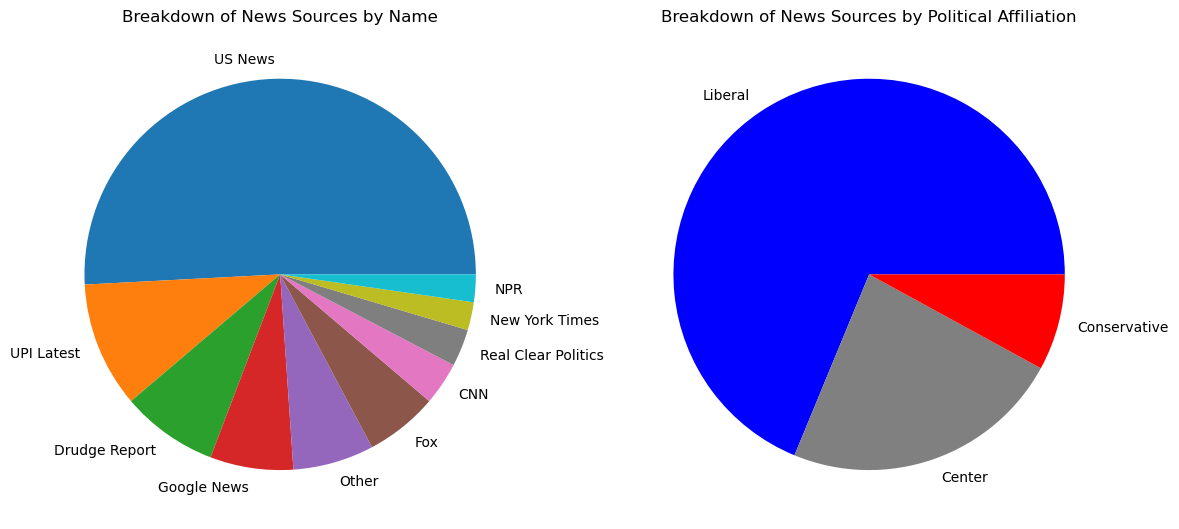

doc_source  US News  UPI Latest  Drudge Report  Google News     Fox     CNN  \
proportion   0.5083      0.1038           0.08       0.0687  0.0601  0.0354   

doc_source  Real Clear Politics  New York Times     NPR  Reuters  Guardian  \
proportion               0.0308          0.0231  0.0228   0.0181    0.0138   

doc_source  Daily Kos  Breitbart  PowerLine  Politico Magazine  
proportion     0.0126     0.0104     0.0091              0.003

politics    Liberal  Center  Conservative
proportion   0.6877  0.2327        0.0796

In [27]:
fig, ax = plt.subplots(1, 2, figsize = (12, 8))
LIBRARY.collapsed_source.value_counts().plot(kind = 'pie',
                                             title = 'Breakdown of News Sources by Name',
                                             ylabel = '',
                                             ax = ax[0])
LIBRARY.politics.value_counts().plot(kind = 'pie',
                                     title = 'Breakdown of News Sources by Political Affiliation',
                                     ylabel = '',
                                     colors = ['blue', 'gray', 'red'],
                                     ax = ax[1],
                                     )
# plt.tight_layout()
# plt.savefig('figures/news_sources_breakdown.png')
plt.show()

display(LIBRARY.doc_source.value_counts(normalize = True).sort_values(ascending = False).to_frame().T)
display(LIBRARY.politics.value_counts(normalize = True).sort_values(ascending = False).to_frame().T)

The top source by far in our dataset is US News, making up around 50% of our documents. My personal favorite, NPR, provides only just over 2% of our sources. A large majority ofour sources are from Liberal-leaning meadia outlets, and Conservative sources seem to be quite underrepresented.

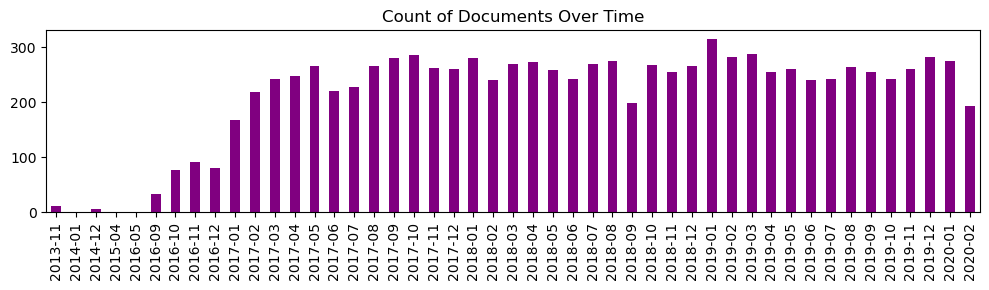

In [28]:
LIBRARY.doc_month.value_counts().sort_index().plot(kind = 'bar', 
                                                   figsize = (10, 3),
                                                   title = 'Count of Documents Over Time',
                                                   color = 'purple',
                                                   xlabel = '')
# plt.tight_layout()
# plt.savefig('figures/news_count_over_time.png')
plt.show()

From the barplot above, we can see that our data prior to November 2016 is pretty sparse, with less than 50 documents. For my time series visualizations later, I may cut off the first few months.

## Top words by TFIDF sum

#### Code

In [5]:
top_words_by_tfidf_sum = VOCAB.query("stopword == False").sort_values('tfidf_sum', ascending = False)[['term', 'tfidf_sum']].reset_index(drop = True)
top10_tfidf = top_words_by_tfidf_sum.head(10).set_index('tfidf_sum')
top10_20_tfidf = top_words_by_tfidf_sum.iloc[10:20, :].set_index('tfidf_sum')
top20_30_tfidf = top_words_by_tfidf_sum.iloc[20:30, :].set_index('tfidf_sum')
styler1 = top10_tfidf.style.set_table_attributes("style='display:inline'")
styler2 = top10_20_tfidf.style.set_table_attributes("style='display:inline'")
styler3 = top20_30_tfidf.style.set_table_attributes("style='display:inline'")

#### Results

In [6]:
display_html(styler1._repr_html_() + 
             styler2._repr_html_() +
             styler3._repr_html_(), raw=True)

term 
 
 
 tfidf_sum 
   
 
 
 
 
 104.397034 
 story 
 
 
 103.933067 
 - 
 
 
 100.805157 
 link 
 
 
 90.505421 
 column 
 
 
 65.784641 
 man 
 
 
 65.418773 
 said 
 
 
 63.446309 
 say 
 
 
 60.799926 
 says 
 
 
 58.299176 
 new 
 
 
 56.471087 
 police 
 
 
 

 
 
 
   
 term 
 
 
 tfidf_sum 
   
 
 
 
 
 54.214121 
 state 
 
 
 51.899059 
 two 
 
 
 51.091115 
 stories 
 
 
 46.310708 
 people 
 
 
 45.184998 
 authorities 
 
 
 42.844012 
 former 
 
 
 42.791520 
 earnings 
 
 
 40.778586 
 first 
 
 
 39.487256 
 full 
 
 
 39.379045 
 officials 
 
 
 

 
 
 
   
 term 
 
 
 tfidf_sum 
   
 
 
 
 
 38.787666 
 one 
 
 
 38.630888 
 coverage 
 
 
 36.883433 
 killed 
 
 
 35.357059 
 woman 
 
 
 34.924963 
 year 
 
 
 34.707255 
 -- 
 
 
 34.564492 
 died 
 
 
 34.355921 
 years 
 
 
 32.301521 
 government 
 
 
 32.110138 
 president

The top words based on TFIDF sum should be the most significant in the dataset. However, we do see that many of the top words in our corpus seem to be stopwords given the topic of news articles. Even so, certain words such as earnings, police, authorities, former, officials, and killed do indicate what kind of news is being covered.

## Word2Vec

#### Code

In [29]:
tsne = TSNE(perplexity = 40,
            n_components = 2,
            init = 'pca',
            n_iter = 2500,
            random_state = 5001)
tsne_coords = tsne.fit_transform(VECTORS)


tsne_df = pd.DataFrame({'term' : VECTORS.index.map(VOCAB.term)}, index = VECTORS.index)
tsne_df['x'] = tsne_coords[:, 0]
tsne_df['y'] = tsne_coords[:, 1]

#### Result

In [8]:
px.scatter(tsne_df, 'x', 'y',
            hover_data = 'term',
            title = 't-SNE plot',
            height = 1000, width = 1000)

What a cool shape! It looks like the words follow a distinct manifold. If this shape was a whale, the left side would be the body and the smaller , right, curvy side would be the tail. The most obvious cluster is tightly packed in the center, near the tail, and consists of number words: 5th, 6th, etc. The model did a really good job of clustering those!

Other than that, for the most part the points are relatively evenly scattered, especially on the side of the head/body of the whale. I looked around in some of the vague clusters in the tail, but didn't find anything super clear or noteworthy.

## Principle Components

#### Code

In [30]:
PC0_lower = LOADINGS.PC0_loading.quantile(0.25)
PC0_upper = LOADINGS.PC0_loading.quantile(0.75)
PC1_lower = LOADINGS.PC1_loading.quantile(0.25)
PC1_upper = LOADINGS.PC1_loading.quantile(0.75)


LOADINGS_clipped = LOADINGS.query(f"PC0_loading > {PC0_lower} & PC0_loading < {PC0_upper}")\
                            .query(f"PC1_loading > {PC1_lower} & PC1_loading < {PC1_upper}")

LOADINGS['term'] = LOADINGS.index.map(VOCAB.term)
top_PC0 = LOADINGS.set_index('PC0_loading').sort_index().tail(10).term.to_frame().rename(columns = {'term' : 'top 10 PC0'})
bottom_PC0 = LOADINGS.set_index('PC0_loading').sort_index().head(10).term.to_frame().rename(columns = {'term' : 'bottom 10 PC0'})
top_PC1 = LOADINGS.set_index('PC1_loading').sort_index().tail(10).term.to_frame().rename(columns = {'term' : 'top 10 PC1'})
bottom_PC1 = LOADINGS.set_index('PC1_loading').sort_index().head(10).term.to_frame().rename(columns = {'term' : 'bottom 10 PC1'})

styler4 = top_PC0.style.set_table_attributes("style='display:inline'")
styler5 = bottom_PC0.style.set_table_attributes("style='display:inline'")
styler6 = top_PC1.style.set_table_attributes("style='display:inline'")
styler7 = bottom_PC1.style.set_table_attributes("style='display:inline'")

#### Results

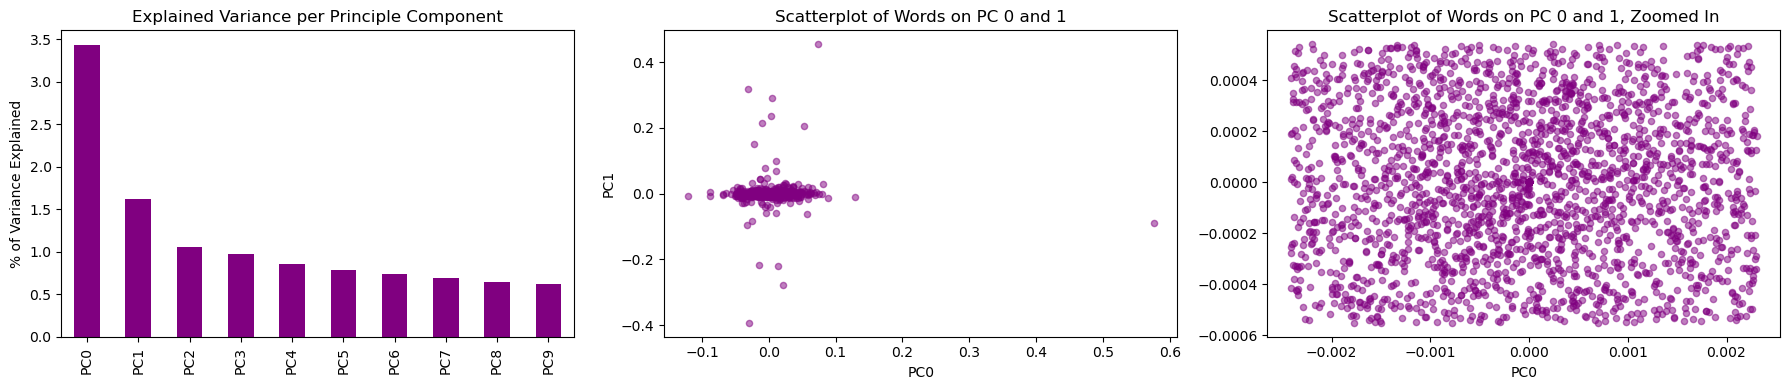

In [31]:
fig, ax = plt.subplots(1, 3, figsize = (18, 4))
(PCS.explained_variance * 100).plot(kind = 'bar',
                                    title = 'Explained Variance per Principle Component',
                                    xlabel = '',
                                    ylabel = '% of Variance Explained',
                                    color = 'purple',
                                    ax = ax[0])
LOADINGS.plot(kind = 'scatter', x = 'PC0_loading', y = 'PC1_loading',
              title = 'Scatterplot of Words on PC 0 and 1',
              ylabel = 'PC1',
              xlabel = 'PC0',
              alpha = 0.5,
              color = 'purple',
              ax = ax[1])
LOADINGS_clipped.plot(kind = 'scatter', x = 'PC0_loading', y = 'PC1_loading',
              title = 'Scatterplot of Words on PC 0 and 1, Zoomed In',
              ylabel = '',
              xlabel = 'PC0',
              alpha = 0.5,
              color = 'purple',
              ax = ax[2])
# plt.tight_layout()
# plt.savefig('figures/principle_components.png')
plt.show()

From the elbow chart, we can see that the first principle component explains much more variance than the following, and the second one explains significantly more than the later ones as well. After the second principle component, the explained variance of all the others hovers around 1%. Even so, the first two principle components together only explain about 5% of the variation in the dataset.

Interesting to see that the loadings on PC0 and PC0 hug around the axes; there are no points with very high or very low values for both PC0 and PC1. However, when you zoon into the interquartile range, you can see that there is an even dispersion along PC0 and PC1, and the same trend dows not appear. Even so, the IQR is very small and close to the origin compared to the outliers.

In [11]:
display_html(styler4._repr_html_() + 
             styler5._repr_html_() + 
             styler6._repr_html_() + 
             styler7._repr_html_(), raw = True)             

top 10 PC0 
 
 
 PC0_loading 
   
 
 
 
 
 0.068153 
 ago 
 
 
 0.069128 
 vote 
 
 
 0.071204 
 taking 
 
 
 0.073617 
 says 
 
 
 0.075332 
 making 
 
 
 0.080174 
 trial 
 
 
 0.080959 
 home 
 
 
 0.089237 
 third 
 
 
 0.129641 
 month 
 
 
 0.575931 
 - 
 
 
 

 
 
 
   
 bottom 10 PC0 
 
 
 PC0_loading 
   
 
 
 
 
 -0.121335 
 official 
 
 
 -0.088456 
 family 
 
 
 -0.087647 
 work 
 
 
 -0.068767 
 beating 
 
 
 -0.068489 
 told 
 
 
 -0.064697 
 despite 
 
 
 -0.055895 
 crashed 
 
 
 -0.053326 
 back 
 
 
 -0.050024 
 sentenced 
 
 
 -0.049113 
 weeks 
 
 
 

 
 
 
   
 top 10 PC1 
 
 
 PC1_loading 
   
 
 
 
 
 0.069276 
 woman 
 
 
 0.079242 
 new 
 
 
 0.100374 
 year 
 
 
 0.149858 
 years 
 
 
 0.206051 
 earnings 
 
 
 0.213628 
 say 
 
 
 0.234944 
 people 
 
 
 0.290048 
 stories 
 
 
 0.318191 
 said 
 
 
 0.454605 
 says 
 
 
 

 
 
 
   
 bottom 10 PC1 
 
 
 PC1_loading 
   
 
 
 
 
 -0.392926 
 one 
 
 
 -0.279345 
 state 
 
 
 -0.220157 
 killed 
 
 
 -0.217544 
 police 
 
 
 -0.094152 
 -- 
 
 
 -0.088425 
 - 
 
 
 -0.083090 
 column 
 
 
 -0.062242 
 week 
 
 
 -0.060318 
 man 
 
 
 -0.058712 
 full

The patterns in the principal components aren't super obvious, but I might venture to say that PC0 could be a scale from official to personal, where the highest loadings correspond to words like vote, trial, and third, whereas the negative loadings correspond to more personal words like family, beating, and crashed. It's difficult to find any significant trend in the PC1 loadings.

## Topics

#### Code

In [32]:
TOPICS['topic'] = ['local news', 'general', 'healthcare', 'national politics',
                   'legal', 'entertainment', 'sports', 'taxes', 'social', 'state politics',
                   'international', 'crime', 'environment', 'police', 'finance']

topics_by_doc = THETA.copy()
topics_by_doc.columns = TOPICS.topic.sort_index()

topics_by_doc['source'] = topics_by_doc.index.map(LIBRARY.doc_source)
topics_by_doc['politics'] = topics_by_doc.index.map(LIBRARY.politics)

topics_by_source = topics_by_doc.groupby('source').sum().loc[:, TOPICS.topic]
topics_by_politics = topics_by_doc.groupby('politics').sum().loc[:, TOPICS.topic]

topics_by_doc['date'] = topics_by_doc.index.map(LIBRARY.doc_month)
topics_by_date = topics_by_doc.groupby('date').sum().loc[:, TOPICS.topic]

normalize = lambda x: x / x.sum()
topics_by_source = topics_by_source.T.sort_values('US News').apply(normalize)
topics_by_politics = topics_by_politics.T.sort_values('Liberal').apply(normalize)
topics_by_date = topics_by_date.apply(normalize, axis = 1)

not_sparse = LIBRARY.doc_month.value_counts()[LIBRARY.doc_month.value_counts() > 100].index
topics_by_date_limited = topics_by_date.loc[not_sparse, :].sort_index()
most_change_limited = abs(topics_by_date_limited.iloc[0, :] - topics_by_date_limited.iloc[-1, :]).sort_values().tail().index

#### Results

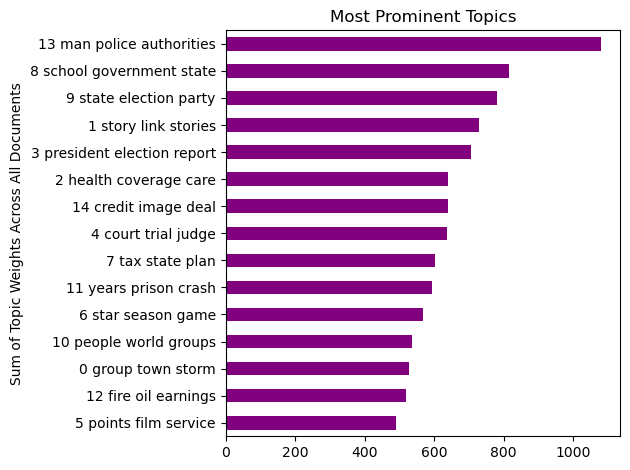

In [33]:
TOPICS.set_index('label').sort_values('doc_weight_sum').plot(kind = 'barh',
                                                             title = 'Most Prominent Topics',
                                                             ylabel = 'Sum of Topic Weights Across All Documents',
                                                             color = 'purple',
                                                             legend = False)
# plt.tight_layout()
# plt.savefig('figures/topics.png')
plt.show()

From this simple bar chart, we can see that our news stories seem to cover crime issues more than any other, followed by social issues and then political issues. Other topics include heathcare, finance, legal, taxes, sports, international news, environment, and entertainment. Topics 9 and 3 seem similar, although 9 may have to do more with state politics and 3 might have to do more with national politics. Topics 11 and 0 are alittle ambiguous, but overall the topics seem pretty clear. I'm happy with these results. Moving forward, I will classify my topics in the following way:

| Topic ID | Label | Topic |
|--|-------------------|------------- |
| 0 | group town storm | local news |
| 1 | story link stories | general  |
| 2 | health coverage care | healthcare |
| 3 | president election report | national politics |
| 4 | court trial judge | legal |
| 5 | points film service | entertainment |
| 6 | star season game | sports |
| 7 | tax state plan | taxes |
| 8 | school government state | social |
| 9 | state election party | state politics |
| 10 | people world groups | international |
| 11 | years prison crash | crime |
| 12 | fire oil earnings | environment |
| 13 | man police authorities | police |
| 14 | credit image deal | finance |

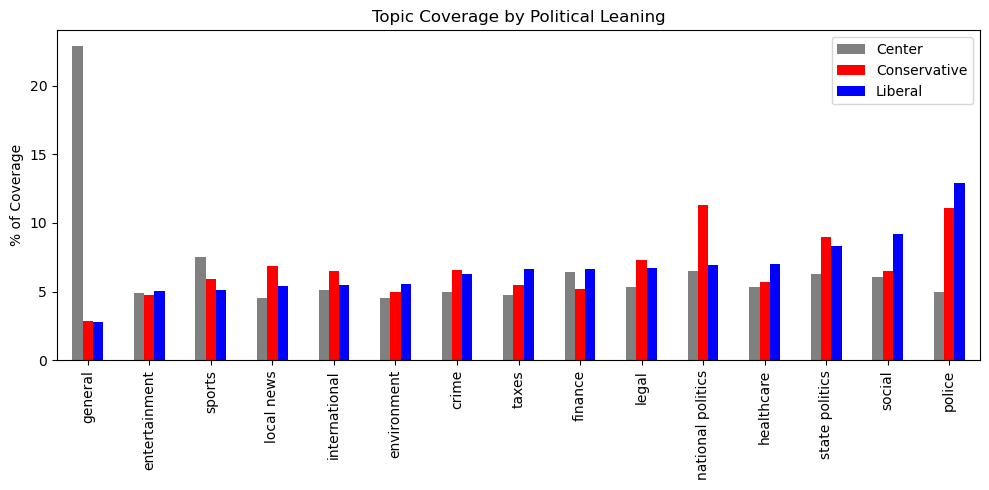

In [34]:
(topics_by_politics.sort_values('Liberal') * 100).plot(kind = 'bar', figsize = (10, 5),
                                            title = 'Topic Coverage by Political Leaning',
                                            xlabel = '',
                                            ylabel = '% of Coverage',
                                            color = ['gray', 'red', 'blue']
                                            )
plt.legend(title = '')
# plt.tight_layout()
# plt.savefig('figures/topic_by_politics.png')
plt.show()

I produced this plot by summing the topic weights from the THETA table across all documents from sources identified as Liberal, Conservative, and Center, then normalizing the results (when the counts were left raw, the Liberal bars where overwhelming because the majority of the sources are liberal).

Observations:

- Conservative news notably reports more on national politics when compared to liberal sources. Conservative sources also cover local news, international news, crime and state politics at a marginally higher rate than liberal sources.
- Liberal sources tend to report more on social and police-related matters, which lines up with the liberal agenda during 2017-2019. Liberal sources also focused slightly more on international news, the environment, taxes, finance, and healthcare when compared to conservative sources.
- Sources with no or minimal political leaning tend to cover general topics overwhelmingly more and matters relating to police much less than liberal and conservative sources. This may be due to the fact that around half of our documents from Center sources are from UPI, an international news agency. Interesting, however, that Center sources wouldn't then focus more on international news. Center sources tend to cover more sports, entertainment, and finance as well, compared to the other topics.
- Overall, it looks like my model indicates conservatives focus more on politics and crime, whereas liberal sources focus more on wellbeing-related matters which seems on par with my experience. Cool!

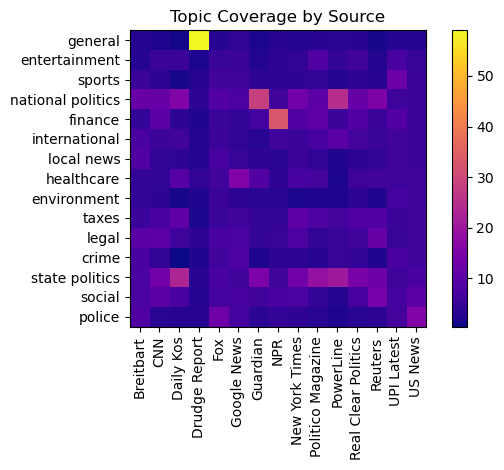

In [35]:
plt.imshow(topics_by_source*100, cmap = 'plasma')
plt.colorbar()
plt.xticks(range(topics_by_source.shape[1]), topics_by_source.columns, rotation = 90) 
plt.yticks(range(topics_by_source.shape[0]), topics_by_source.index)
plt.title('Topic Coverage by Source')
# plt.tight_layout()
# plt.savefig('figures/topic_by_source.png')
plt.show()

I produced this plot by summing the topic weights from the THETA table across all documents from each source, then normalizing the results (when the counts were left raw, the US News column was the only one with a lighter color). The colorbar on the right represents the percentage of the time that a source covers a certain topic.

Observations: 

- The "general" coverage came mostly from the Drudge Report, with almost 60% of the Drudge Report documents in our dataset covering the "general" category.
- The Guardian reports more national politics than anything else.
- NPR reports more on finance than anything else.
- Google News reports more on healthcare than anything else.
- UPI latest reports more on sports than anything else.
- Most sources cover politics more than any other topic.

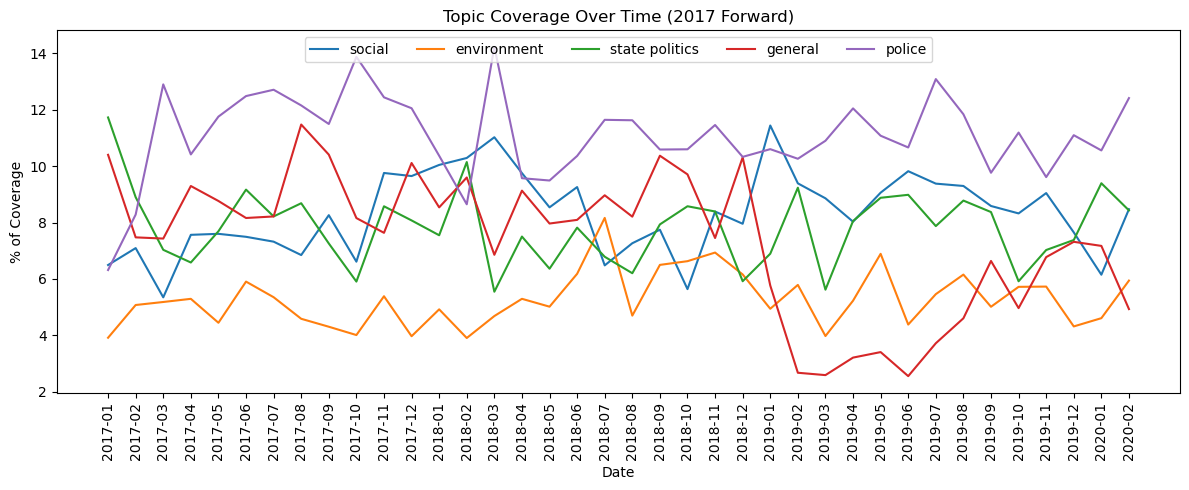

In [36]:
(topics_by_date_limited[most_change_limited] * 100).plot(figsize = (12, 5),
                    title = 'Topic Coverage Over Time (2017 Forward)',
                    xlabel = 'Date',
                    ylabel = '% of Coverage',
                   )
plt.legend(loc = 'upper center', ncol = 5)
plt.xticks(range(topics_by_date_limited.shape[0]), topics_by_date_limited.index, rotation = 90)
# plt.tight_layout()
# plt.savefig('figures/topic_over_time.png')
plt.show()

This plot shows the change in topic coverage over time. It shows the aggregate sum of topic coverage across documents for each month, produced in the same way as the previos two. I limited the scope to after November 2016, because a dearth of data points before that period caused large spikes in the percent coverage for some specific topics that made it difficult to read the majority of the trends. Since 15 topics was too many to visualize, I picked the 5 topics that had the highest change in coverage from the beginning to the end of the time period to display here.

Observations:
- There is a large increase in police-related coverage at the beginning of 2017, and the coverage is pretty steady after that, peaking again in March 2018 after a brief trough. This trend may be related to an increasing awareness and demand for change around police brutality in America.
- Environmental coverage sees a spike in mid-2018, which corresponds to when people started talking more seriously about climate change, and a slight increase in coverage is generally sustained.
- There is a huge trough in general coverage in early 2019. since the "general" category is a little ambiguous, it's difficult to tell what this may correspond to in the world.
- State politics coverage dips in the beginning of this period and maintains a lower trend. Perhaps this trend is related to the 2016 presidential election, which was very controversial, and media sources began to cover national politics more than state politics.
- Finally, we see a generally consistent trend in social coverage, with a hill in late 2017-early 2018, which could possibly correspond to the #MeToo movement, and another sharp peak in early 2019.

## Sentiment

### Code

In [37]:
SENTIMENTS['term'] = SENTIMENTS.index.map(VOCAB.term)
doc_sentiments = TOKEN.reset_index().merge(SENTIMENTS, on = 'term', how = 'left')
doc_sentiments = doc_sentiments.loc[~doc_sentiments.polarity.isna(), ['doc_id'] + SENTIMENTS.columns.tolist()]
doc_sentiments = doc_sentiments.groupby('doc_id').sum().drop(columns = 'term')
doc_sentiments = DOC.join(doc_sentiments).drop(columns = 'doc_content')

emotions = ['anger', 'anticipation', 'disgust', 'fear', 
            'joy', 'sadness', 'surprise', 'trust']
polarity = ['positive', 'negative', 'polarity']
doc_sentiments['doc_source'] = doc_sentiments.index.map(LIBRARY.doc_source)
doc_sentiments['politics'] = doc_sentiments.index.map(LIBRARY.politics)

emotion_by_source = doc_sentiments.groupby('doc_source').sum().loc[:, emotions]
emotion_by_politics = doc_sentiments.groupby('politics').sum().loc[:, emotions]
polarity_by_source = doc_sentiments.groupby('doc_source').sum().loc[:, polarity]
polarity_by_politics = doc_sentiments.groupby('politics').sum().loc[:, polarity]

emotion_by_source = emotion_by_source.T.sort_values('US News').apply(normalize)
emotion_by_politics = emotion_by_politics.T.sort_values('Liberal').apply(normalize)
polarity_by_source = polarity_by_source.T.sort_values('US News').apply(normalize)
polarity_by_politics = polarity_by_politics.T.sort_values('Liberal').apply(normalize)

doc_sentiments['date'] = doc_sentiments.index.map(LIBRARY.doc_month)
emotion_by_date_limited = doc_sentiments.groupby('date').sum().loc[not_sparse, emotions]
polarity_by_date_limited = doc_sentiments.groupby('date').sum().loc[not_sparse, polarity]

emotion_by_date_limited = emotion_by_date_limited.apply(normalize, axis = 1)
polarity_by_date_limited = polarity_by_date_limited.apply(normalize, axis = 1)

vader_analyzer = SentimentIntensityAnalyzer()
vader_sentences = TOKEN.loc[:, ['doc_id', 'sent_num', 'token']]
vader_sentences.token = vader_sentences.token + ' '
vader_sentences = vader_sentences.groupby(['doc_id', 'sent_num']).sum().rename(columns = {'token' : 'sentence'})
vader_scores = vader_sentences.sentence.apply(vader_analyzer.polarity_scores).apply(lambda x: pd.Series(x))

vader_by_doc = vader_scores.reset_index().groupby('doc_id').sum().drop(columns = 'sent_num')
vader_by_doc['date'] = vader_by_doc.index.map(LIBRARY.doc_month)
vader_by_date_limited = vader_by_doc.groupby('date').sum().loc[not_sparse, :]

vader_by_date_limited = vader_by_date_limited.apply(normalize, axis = 1)
vader_by_date_limited.columns = ['negative', 'neutral', 'positive', 'polarity']

### Results

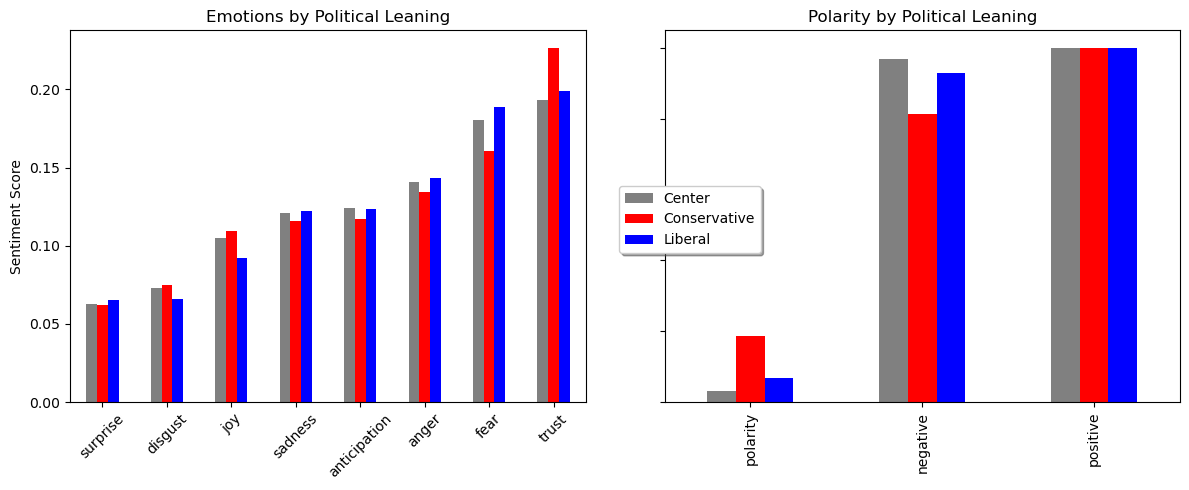

In [38]:
fig, ax = plt.subplots(1, 2, figsize = (12, 5))
emotion_by_politics.sort_values('Liberal').plot(kind = 'bar',
                                                title = 'Emotions by Political Leaning',
                                                xlabel = '', rot = 45,
                                                ylabel = 'Sentiment Score',
                                                sharey = True,
                                                legend = False,
                                                color = ['gray', 'red', 'blue'],
                                                ax = ax[0])
polarity_by_politics.sort_values('Liberal').plot(kind = 'bar',
                                                 title = 'Polarity by Political Leaning',
                                                 color = ['gray', 'red', 'blue'],
                                                 ax = ax[1])

plt.legend(title = '', bbox_to_anchor=(0.2, .6), shadow = True)
# plt.tight_layout()
# plt.savefig('figures/sentiment_by_politics.png')
plt.show()

I produced these plots the same way I produced the topic plots above.

In my sample, conservative documents demonstrate more positive emotions like joy and trust, while liberal and Center sources demonstrate more negative emotions like fear, anger, and sadness. This is supported by the overall polarity in the figure on the left: all political leanings seem to have the same amount of positivity, although conservative sources tend to have less negativity than Center and liberal sources, leading to a higher (more positive) total polarity for conservative sources. All three categories of political leanings tend to express more trust, fear, and anger than the other emotions.

In [39]:
plt.figure(figsize = (12, 5))
ax1 = plt.subplot(1, 2, 1)
plt.imshow(emotion_by_source.sort_values('US News') * 100, cmap = 'plasma')
plt.colorbar()
plt.xticks(range(emotion_by_source.shape[1]), emotion_by_source.columns, rotation = 90) 
plt.yticks(range(emotion_by_source.shape[0]), emotion_by_source.index)
plt.title('Emotions by Source')
ax2 = plt.subplot(1, 2, 2)
polarity_by_source.T.sort_values('negative', ascending = False).plot(kind = 'bar',
                                                title = 'Polarity by Source',
                                                xlabel = '',
                                                ylabel = 'Sentiment Score',
                                                color = ['purple', 'green', 'red'],
                                                ax = ax2)
# plt.tight_layout()
# plt.savefig('figures/sentiment_by_source.png')
plt.show()

The heatmap above shows us similar information to the bar charts, with a little more nuance. These plots were created using the same methodology as the topic charts.

Observations:
- Drudge Report, Fox, Google News, UPI Latest, and US News display less trust than the other news sources. These include all three categories of political leanings.
- CNN, Guardian, New York Times, PowerLine, and Reuters show less sadness than the other sources. This is interesting because only one of those (PowerLine) is conservative, yet the overall conservative score from the bar chart above is lower for sadness than the other two political leanings.
- The Guardian seems to write with more anticipation thatn other sources.
- All of the sources have about the same amount of positive language, but with varying levels of negative language. Politico Magazine, Fox, US News, Google News, and Drudge Report are the only sources with negative total polarity.
- Drudge Report has by far the highest negative sentiment and the lowest polarity overall.
- The most positive sources are CNN, Reuters, NPR, and NY Times. Three of these four (CNN, Reuters, and NY Times) line up with the ones that show less sadness in the heatmap.

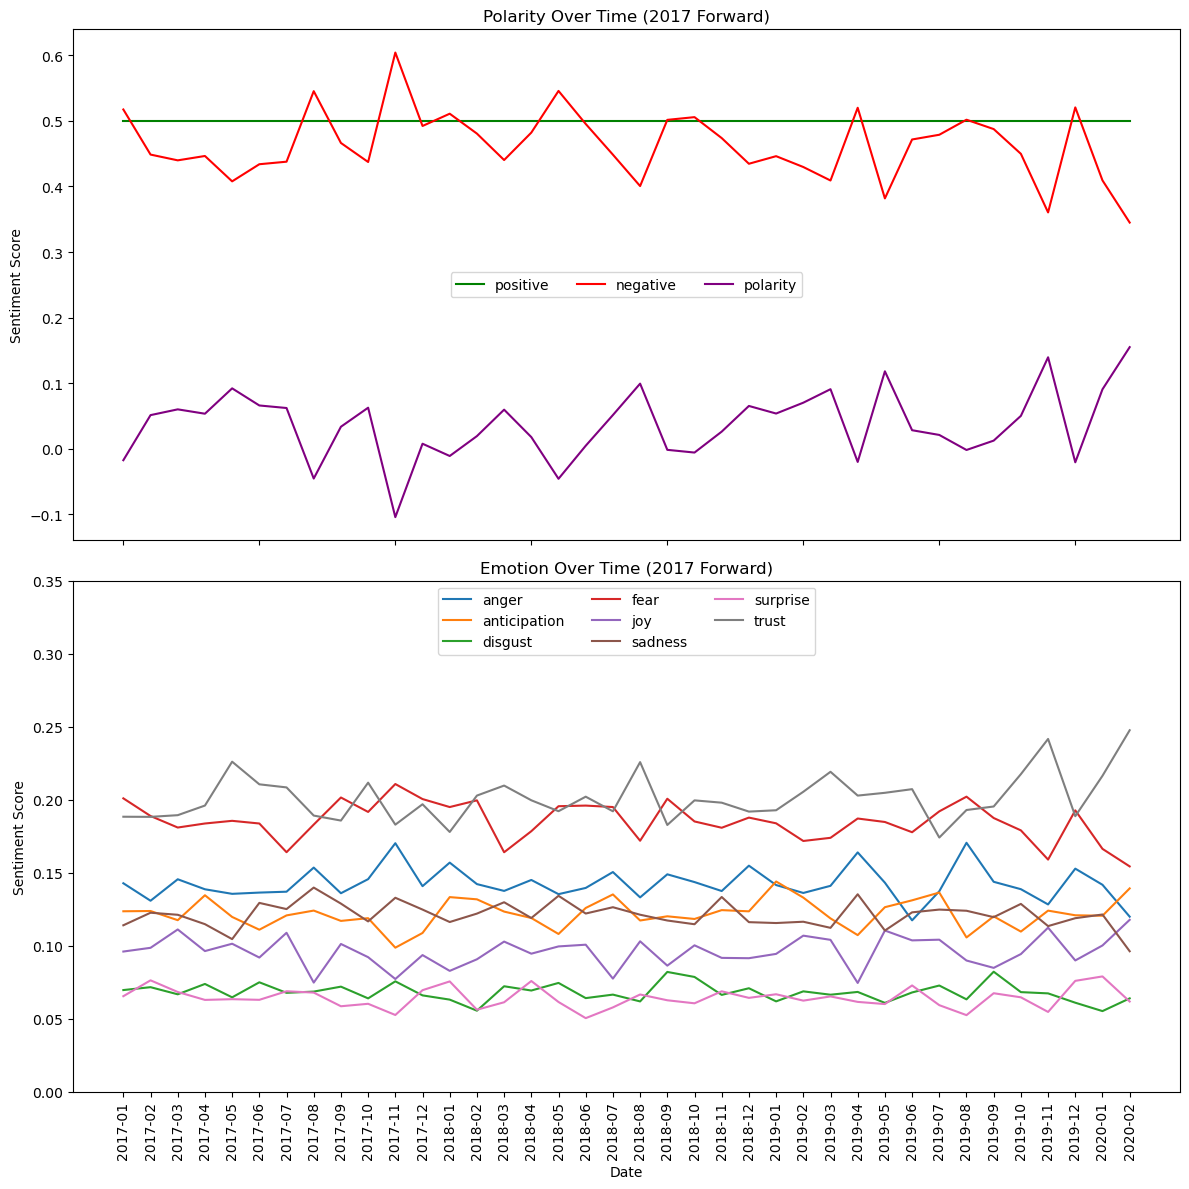

In [40]:
# fig = plt.figure(figsize = (12, 10))
# ax1 = plt.subplot(2, 1, 1)
fig, ax = plt.subplots(2, 1, figsize = (12, 24))
polarity_by_date_limited.plot(figsize = (12, 6), title = 'Polarity Over Time (2017 Forward)',
                              ylabel = 'Sentiment Score',
                              sharex = True,
                              color = ['green', 'red', 'purple'],
                              ax = ax[0])
ax[0].legend(loc = 'center', ncol = 3)
# ax2 = plt.subplot(2, 1, 2)
emotion_by_date_limited.plot(figsize = (12, 12), title = 'Emotion Over Time (2017 Forward)',
                              xlabel = 'Date',
                              ylabel = 'Sentiment Score',
                             ylim = (0, 0.35),
                              ax = ax[1])
ax[1].legend(loc = 'upper center', ncol = 3)
plt.xticks(range(topics_by_date_limited.shape[0]), topics_by_date_limited.index, rotation = 90)
# plt.tight_layout()
# plt.savefig('figures/sentiment_over_time.png')
plt.show()

For the same reasons as stated in the Topic section above, I chose to start my time series investigation in January 2017. These line plots show the aggregated sentiments of each month across all documents.

Observations:
- There is a spike in polarity around August 2018 that corresponds with a spike in trust, a trough in fear, a troughin anger, and a spike in joy. All of these line up very nicely.

#### VADER Sentiments

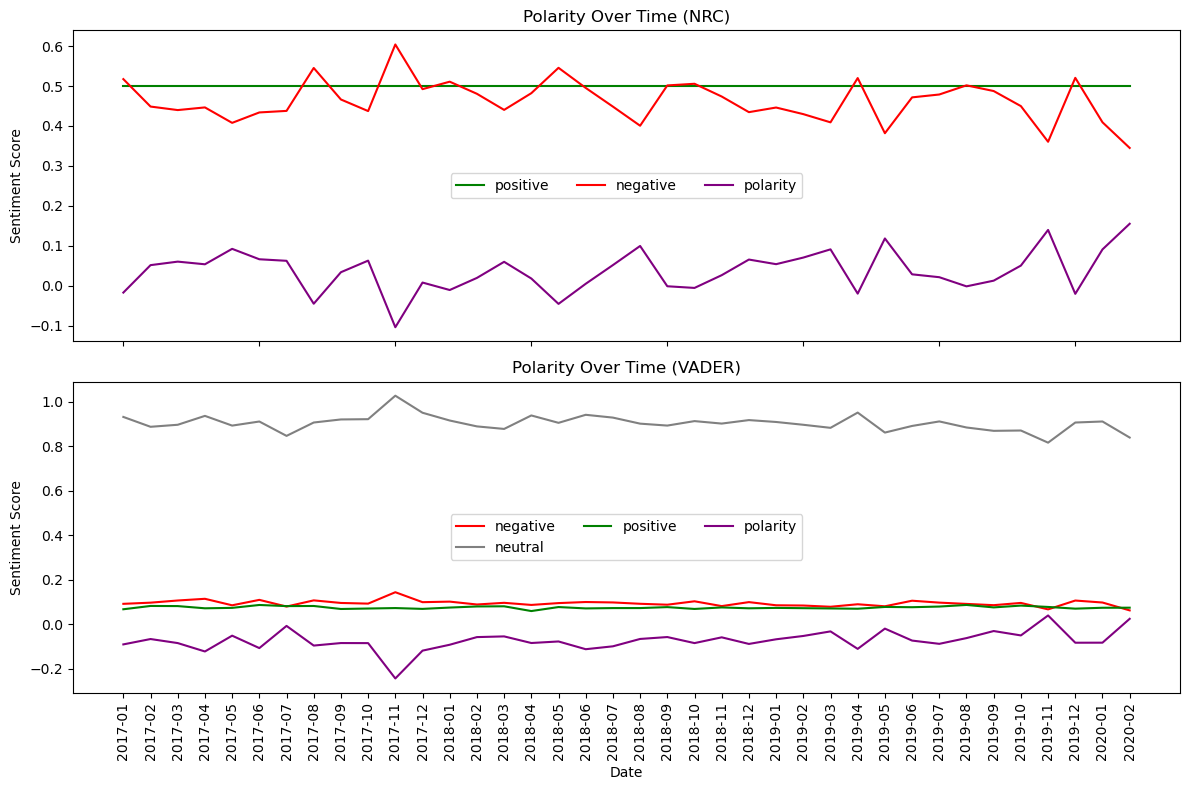

In [41]:
fig, ax = plt.subplots(2, 1, figsize = (12, 24))
polarity_by_date_limited.plot(figsize = (12, 6), title = 'Polarity Over Time (NRC)',
                              ylabel = 'Sentiment Score',
                              sharex = True,
                              color = ['green', 'red', 'purple'],
                              ax = ax[0])
ax[0].legend(loc = 'center', ncol = 3)
vader_by_date_limited.plot(figsize = (12, 8),
                           title = 'Polarity Over Time (VADER)',
                           ylabel = 'Sentiment Score',
                           color = ['red', 'gray', 'green', 'purple'],
                           xlabel = 'Date',
                           ax = ax[1]
                          )
plt.xticks(range(topics_by_date_limited.shape[0]), topics_by_date_limited.index, rotation = 90)
ax[1].legend(loc = 'center', ncol = 3)
# plt.tight_layout()
# plt.savefig('figures/polarity_over_time_comparison.png')
plt.show()

It looks like the VADER sentiments generally match up with the sentiments from NRC, although VADER assigns a lot more neutral instead of the positive and negative sentiments cancelling out. Both positive and negative sentiments from VADER are very low, and the sentences are dominated by neutral words.